In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

In [3]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

## Change the path to the pickled file

In [4]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/pickle_files/sim_tadpole9_subtype2.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [5]:
pkl["samples_likelihood"].shape

(3000000, 1)

### Check that the MCI and CN/AD files have same column names

In [6]:
# MCI and CN/AD data
cn_ad_path = "/home/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm_final_n327.csv"
df_cnad = pd.read_csv(cn_ad_path)
mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm_mci.csv"
df_mci = pd.read_csv(mci_path)
df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
assert all(df_mci.columns == df_cnad.columns)

## Subtyping and Staging the subjects

### Get the probability matrices for CN/AD

In [7]:
# Get the mixture model for the CN/AD subjects
k=119
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdf(None, X[:, i])

L_no = process_L(L_no)
L_yes = process_L(L_yes)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


### Create a SuStaIn object to call the associated methods

In [8]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [24,24,24,24,23]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 2
p_absorb = 0.3
N_em = 100
SuStaInLabels = df_cnad.columns[:k].tolist()
dataset_name            = 'sim_tadpole9'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

### Get the prob mat for the mci subjects

In [9]:
# Get the prob mat for the mci subjects
X_mci = df_mci.iloc[:,:k].values
prob_mat_mci = mixture_model.get_prob_mat(X_mci, mixture_models)
L_no_mci = prob_mat_mci[:,:,0]
L_yes_mci = prob_mat_mci[:,:,1]
L_no_mci = process_L(L_no_mci)
L_yes_mci = process_L(L_yes_mci)

### Subtype and Stage the MCI subjects

In [10]:
# Subtype and Stage the MCI subjects
last_N = 100000
N_samples = 1000
sustainData_newData = sEBMSustainData(L_yes_mci, L_no_mci, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci, ll = sustain.subtype_and_stage_individuals(sustainData_newData, shape_seq, samples_sequence, samples_f, N_samples)


In [11]:
np.mean(ll), np.std(ll)

(-537130.7224354156, 42.62285942410651)

### Subtype and Stage CN/AD data

In [12]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad, _ = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence, samples_f, N_samples)


In [13]:
n_cnad = ml_subtype_cnad.shape[0]
n_mci = ml_subtype_mci.shape[0]
unique_cnad, counts_cnad = np.unique(ml_subtype_cnad, return_counts=True)
unique_mci, counts_mci = np.unique(ml_subtype_mci, return_counts=True)

fraction_cnad = {}
dict_cnad = dict(zip(unique_cnad, counts_cnad))
for k, v in dict_cnad.items():
    fraction_cnad[k] = v/n_cnad
    
fraction_mci = {}
dict_mci = dict(zip(unique_mci, counts_mci))
for k, v in dict_mci.items():
    fraction_mci[k] = v/n_mci
    
print("CN/AD fractions across subtypes : \n", fraction_cnad)
print("MCI fractions across subtypes : \n", fraction_mci)

CN/AD fractions across subtypes : 
 {0.0: 0.5596330275229358, 1.0: 0.327217125382263, 2.0: 0.11314984709480122}
MCI fractions across subtypes : 
 {0.0: 0.3738656987295826, 1.0: 0.35753176043557167, 2.0: 0.26860254083484575}


### Get subjects for a givensubtype

### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [14]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.values.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
cnad_solved[["PTID", "EXAMDATE"]] = df_cnad[["PTID", "EXAMDATE"]]

In [15]:
# DataFrame for MCI subjects
array_subtype_stage_mci = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_solved = pd.DataFrame(data=array_subtype_stage_mci, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
mci_solved[["PTID", "EXAMDATE"]] = df_mci[["PTID", "EXAMDATE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [16]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"MCI"})

In [17]:
def append_counts_bar(df, st_min=0, st_max=5):
    if df["stage"].min() > st_min:
        new_row = {"stage":0.0, "DX":"Controls", "value":0.0}
#         new_row = {"stage":0.0, "DX":"MCI", "value":0.0}
#         new_row = {"stage":0.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    if df["stage"].max() < st_max:
        new_row = {"stage":5.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    return df

In [18]:
subtype_select = 2
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","MCI"]).reset_index()

In [19]:
counts_bar = append_counts_bar(counts_bar)

<ipython-input-17-d65cc012ca6a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
<ipython-input-17-d65cc012ca6a>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [20]:
counts_bar["stage"] = counts_bar["stage"].astype(int)

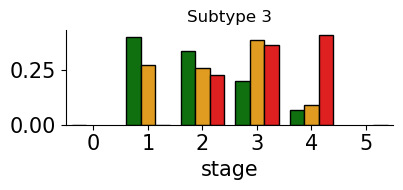

In [21]:
fig, ax = plt.subplots(figsize=(4,2))
hue_order=["Controls", "MCI", "AD"]
palette = ["g", "orange","r"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("stage", fontsize=15)
ax.set_ylabel("")
    
ax.get_legend().remove()

ax.tick_params(axis='both', which='major', labelsize=15)


# ax.set_ylim([0])
ax.set_title("Subtype {}".format(int(subtype_select+1)), fontsize=12)
sns.despine()
plt.tight_layout()
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures/subtypes_3/"
fname = "stage_hist_subtype_{}.png".format(int(subtype_select+1))
fig.savefig(os.path.join(fig_path, fname), dpi=300, transparent=True)


In [22]:
df_total = pd.concat([df_mci, df_cnad], axis=0)
SuStaIn_df = pd.merge(df_total, final_df, on=["PTID", "EXAMDATE"])
SuStaIn_df = SuStaIn_df[SuStaIn_df["DX_y"]=="MCI"]
MRI_cols = SuStaIn_df.columns.tolist()[:119]
SuStaIn_cols = MRI_cols + ["subtype", "stage"]
SuStaIn_df_rel = SuStaIn_df[SuStaIn_cols]
SuStaIn_df_rel["subtype"] += 1
# df_total

<ipython-input-22-a01c38073e78>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SuStaIn_df_rel["subtype"] += 1


In [23]:
from sklearn.manifold import TSNE

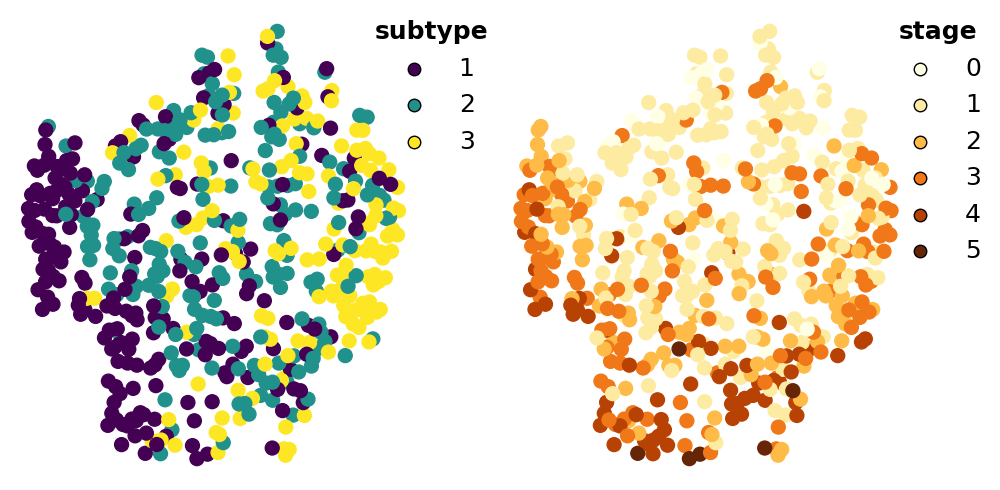

In [24]:
# palette="autumn_r",
SuStaIn_embedded = TSNE(n_components=2, learning_rate='auto',
                       init='pca', perplexity=30, random_state=0).fit_transform(SuStaIn_df_rel[MRI_cols].values)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                palette = "viridis", s = 100, ax = ax[0],edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["subtype"].astype(int))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                s = 100, ax = ax[1], palette="YlOrBr", edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["stage"].astype(int))
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="subtype",
             title_fontproperties={'weight':'bold', 'size':18})
ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="stage",
             title_fontproperties={'weight':'bold', 'size':18})

for ha in ax[0].legend_.legendHandles:
    ha.set_edgecolor("k")

for ha in ax[1].legend_.legendHandles:
    ha.set_edgecolor("k")
    
# ax[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0., frameon=False)
ax[0].axis("off")
ax[1].axis("off")
fig.tight_layout()
fig.savefig("/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures/subtypes_3/t-SNE_MCI_full.png", dpi=400)


# Progression curves

In [25]:
cmap = cm.get_cmap('autumn_r')
delta_years = list(range(5,8))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

## Prepare longitudinal data

In [26]:
def prepare_logitudinal_data(first_visit_df):
    # Read the MRI data across all subjects
    path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm.csv"
    df = pd.read_csv(path)
    sid = df["Measure:volume"].apply(lambda x: x.split("-",1))
    df_sid = pd.DataFrame(sid.tolist(), columns=["sid", "time"])
    sid_time = df_sid["time"].apply(lambda x: x.split("_",1))
    df_sid_time = pd.DataFrame(sid_time.tolist(), columns=["date", "time"])
    df_concat = pd.concat([df_sid, df_sid_time], axis=1)[["sid", "date"]]
    df_concat["date"] = pd.to_datetime(df_concat["date"])

    # Read the ADNIMERGE file     
    adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
    df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]
    df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])
    merged_df = df_adnimerge.merge(df_concat, left_on=["PTID", "EXAMDATE"], right_on=["sid", "date"])
    
    # longitudinal_records
    longitudinal_records = df_adnimerge.sort_values(["PTID", "EXAMDATE"]).set_index("PTID").dropna(subset=["DX"])
    d = {}
    for i, row in first_visit_df.iterrows():
        ptid = row["PTID"]
        d[ptid] = longitudinal_records.loc[ptid, :]
    return d, merged_df
    

In [27]:
d, merged_df = prepare_logitudinal_data(final_df)
mci_demographics = merged_df[merged_df["DX"].isin(["MCI"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")
cn_demographics = merged_df[merged_df["DX"].isin(["CN"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

<ipython-input-26-2b455cddab5a>:14: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]


In [34]:
Su = 0.0
mci_subtype = mci_solved[mci_solved["subtype"]==Su]
fraction = mci_subtype.shape[0]/mci_solved.shape[0]
cox_mci = mci_demographics[mci_demographics["PTID"].isin(mci_subtype["PTID"])]
dict_stage = dict(zip(mci_subtype["PTID"],mci_subtype["stage"]))

<ipython-input-37-3d2e203cafe7>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mci_subtype["convert"] = mci_subtype["PTID"].map(d2)
<ipython-input-37-3d2e203cafe7>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_mci["convert"] = cox_mci["PTID"].map(d2)
<ipython-input-37-3d2e203cafe7>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

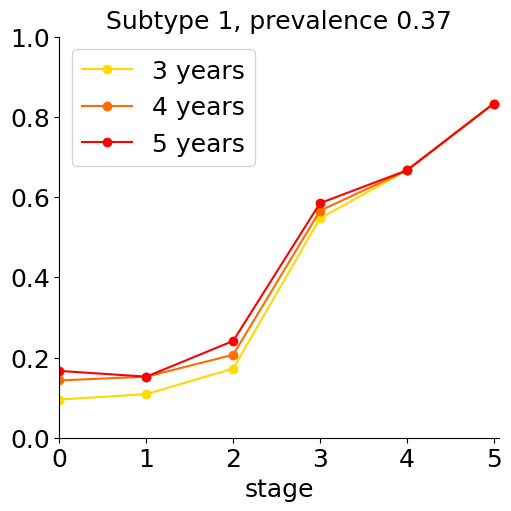

In [37]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))
save_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures/subtypes_3/"

for dy in delta_years:
    d2 = {}
    dtd = {}
    for i, row in mci_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=dy, months=0)
        ptid_df = d[ptid].sort_values(["EXAMDATE"])
        ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                            & (ptid_df["EXAMDATE"] <= examdate_max)]
        srs = ptid_forward_df["DX"]
        if type(srs) is str:
            cnvrt = 0
        else:
            first_dx = srs[0]
            assert first_dx == "MCI"
            bool_srs = srs == "Dementia"
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]
        dtd[ptid] = time_delta.days
        d2[ptid] = cnvrt

    mci_subtype["convert"] = mci_subtype["PTID"].map(d2)
    df_convert = mci_subtype[mci_subtype["convert"]==1]
    dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(dfc["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(mci_subtype["stage"])
    d3 = {}
    for i in range(6):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d3[i]=r
    # print(stats.kendalltau(list(d3.keys()), list(d3.values())))
    x = np.array(list(d3.keys()))
    y = np.array(list(d3.values()))
    ax.plot(x, y, label=str(dy) + " years", marker="o", color=d_colors[dy])
    ax.set_xlabel("stage", fontsize=18)
    cox_mci["convert"] = cox_mci["PTID"].map(d2)
    cox_mci["time"] = cox_mci["PTID"].map(dtd)
    cox_mci["subtype"] = Su
    cox_mci["stages_inferred"] = cox_mci["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}.csv".format(Su,dy)
    cox_mci.to_csv(os.path.join(save_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# if Su == 0.0:
#     ax.set_ylabel("Fraction of MCI subjects\nconverted to AD/Dementia", fontsize=18)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,1])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "mci_subtype_{}.png".format(Su)
fig.savefig(os.path.join(save_path, fig_name), dpi=450)


## Controls progression

In [40]:
d, merged_df = prepare_logitudinal_data(final_df)
cn_demographics = merged_df[merged_df["DX_bl"].isin(["CN"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

<ipython-input-32-2b455cddab5a>:14: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]


In [41]:
merged_df

,PTID,DX_bl,DX,EXAMDATE,VISCODE,AGE,PTGENDER,PTEDUCAT,APOE4,sid,date
0,011_S_0003,AD,Dementia,2006-03-13,m06,81.3,Male,18,1.0,011_S_0003,2006-03-13
1,011_S_0003,AD,Dementia,2006-09-12,m12,81.3,Male,18,1.0,011_S_0003,2006-09-12
2,011_S_0003,AD,Dementia,2007-09-12,m24,81.3,Male,18,1.0,011_S_0003,2007-09-12
3,011_S_0005,CN,CN,2006-03-09,m06,73.7,Male,16,0.0,011_S_0005,2006-03-09
4,011_S_0005,CN,CN,2006-09-05,m12,73.7,Male,16,0.0,011_S_0005,2006-09-05
...,...,...,...,...,...,...,...,...,...,...,...
2714,013_S_1276,CN,CN,2010-04-20,m36,71.8,Female,14,0.0,013_S_1276,2010-04-20
2715,031_S_4021,CN,NaN,2011-07-26,m03,66.5,Male,20,0.0,031_S_4021,2011-07-26
2716,031_S_4021,CN,CN,2011-10-20,m06,66.5,Male,20,0.0,031_S_4021,2011-10-20
2717,031_S_4021,CN,CN,2012-04-26,m12,66.5,Male,20,0.0,031_S_4021,2012-04-26


In [46]:
Su = 2.0
cn_subtype = cnad_solved[(cnad_solved["subtype"]==Su) & (cnad_solved["DX"]==0.0)]
fraction_cn = cn_subtype.shape[0]/cnad_solved[cnad_solved["DX"]==0.0].shape[0]
cox_cn = cn_demographics[cn_demographics["PTID"].isin(cn_subtype["PTID"])]
dict_stage = dict(zip(cn_subtype["PTID"],cn_subtype["stage"]))

<ipython-input-47-cc4cc7c99a53>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cn_subtype["convert"] = cn_subtype["PTID"].map(d2)
<ipython-input-47-cc4cc7c99a53>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_cn["convert"] = cox_cn["PTID"].map(d2)
<ipython-input-47-cc4cc7c99a53>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

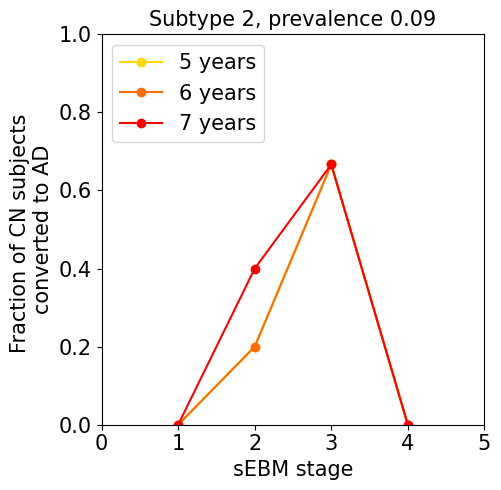

In [47]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(5,8))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))
save_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures/subtypes_3/"

for dy in delta_years:
    d2 = {}
    dtd = {}
    for i, row in cn_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=dy, months=0)
        ptid_df = d[ptid].sort_values(["EXAMDATE"])
        ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                            & (ptid_df["EXAMDATE"] <= examdate_max)]
        srs = ptid_forward_df["DX"]
        if type(srs) is str:
            cnvrt = 0
        else:
            first_dx = srs[0]
            assert first_dx == "CN"
            bool_srs = srs != first_dx
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]
        dtd[ptid] = time_delta.days
        d2[ptid] = cnvrt

    cn_subtype["convert"] = cn_subtype["PTID"].map(d2)
    df_convert = cn_subtype[cn_subtype["convert"]==1]
    dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(dfc["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(cn_subtype["stage"])
    d3 = {}
    for i in range(6):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d3[i]=r
    # print(stats.kendalltau(list(d3.keys()), list(d3.values())))
    x = np.array(list(d3.keys()))
    y = np.array(list(d3.values()))
    ax.plot(x, y, label=str(dy) + " years", marker="o", color=d_colors[dy])
    ax.set_xlabel("sEBM stage", fontsize=15)
    cox_cn["convert"] = cox_cn["PTID"].map(d2)
    cox_cn["time"] = cox_cn["PTID"].map(dtd)
    cox_cn["subtype"] = Su
    cox_cn["stages_inferred"] = cox_cn["PTID"].map(dict_stage)
    fname = "CN_cox_df_subtype_{}_delta_yrs_{}.csv".format(Su,dy)
    cox_cn.to_csv(os.path.join(save_path,fname))
    
ax.set_ylabel("Fraction of CN subjects \nconverted to AD", fontsize=15)
ax.set_title("Subtype {}, prevalence {}".format(int(Su), np.round(fraction_cn, 2)), 
             fontsize=15)
ax.set_xlim([0,5])
ax.set_ylim([0,1.0])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=15)
plt.tight_layout()
# plt.xlim([0,6])
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc=2)
fig_name = "cn_subtype_{}.png".format(Su)
fig.savefig(os.path.join(save_path, fig_name), dpi=300)


## Longitudinal data analysis

In [43]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [44]:
df_long.shape

(3293, 121)

In [45]:
len(set(df_long["sid"]))

873

In [46]:
327 + 551

878

In [47]:
df_long.shape

(3293, 121)

In [48]:
set(final_df["PTID"]) - set(df_long["sid"])

set()

In [49]:
len(set(final_df["PTID"]))

873

In [50]:
all(df_long.columns[:119] == df_cnad.columns[:119])

True

In [51]:
### List of CN/AD and MCI subjects

In [52]:
# mci_subj_0 = mci_solved[mci_solved["subtype"]==0.0]["PTID"].tolist()
# mci_subj_1 = mci_solved[mci_solved["subtype"]==1.0]["PTID"].tolist()

In [53]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [54]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [55]:
k = 119

In [56]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [57]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)


In [58]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])

In [59]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_long_subtype_stage = pd.DataFrame(mci_long_subtype_stage, columns=["subtype", "stage"])
mci_long_subtype_stage[["sid", "date"]] = df_long_mci.reset_index()[["sid", "date"]]
mci_long_subtype_stage["date"] = pd.to_datetime(mci_long_subtype_stage["date"])
df_followup = mci_long_subtype_stage
df_followup = df_followup.sort_values(["sid", "date"])

In [60]:
def get_pairs(vec):
    trns = []
    l = vec.shape[0]
    for i in range(1,l):
        trns.append((vec[:i][-1], vec[i:][0]))
    return trns

sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["subtype"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["delta_years"] = delta_years
<ipython-input-60-4e72b15abedd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [61]:
count = np.zeros((3,3))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

In [62]:
save_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/figures/subtypes_3/'

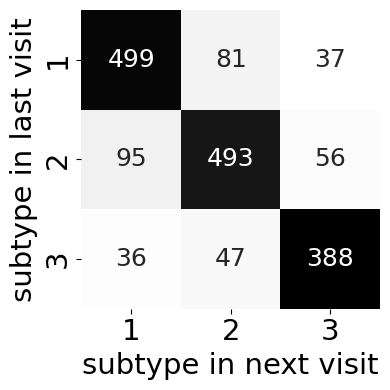

In [63]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("subtype in last visit", fontsize=21)
ax.set_xlabel("subtype in next visit", fontsize=21)
ax.set_xticklabels([1,2,3], fontsize=21)
ax.set_yticklabels([1,2,3], fontsize=21)
fig_name = "longitudinal_subtype_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(save_path, fig_name), dpi=300, transparent=True)

In [64]:
count.trace() , count.sum()

(1380, 1732)

In [65]:
count.trace()/count.sum()

0.7967667436489607

In [72]:
x_ = np.array([0.35,0.27,0.15,0.23])
np.dot(x_,x_)

0.2708

In [73]:
mci_long_subtype_stage[["sid", "date"]]

,sid,date
0,072_S_4383,2015-02-05
1,099_S_4157,2011-08-23
2,041_S_0679,2006-07-20
3,016_S_2007,2010-06-17
4,130_S_4417,2012-04-20
...,...,...
2278,009_S_4324,2012-11-14
2279,941_S_4764,2013-06-10
2280,128_S_2123,2011-11-01
2281,052_S_1352,2008-04-21


In [74]:
df_long_mci

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume,sid,date
0,14956,1082,16344,50923,5984,3465,5322,1677,1948,1954,...,19712,11659,10911,9021,981,2216,1007,6070,072_S_4383,2/5/15
1,18377,1102,12179,42885,4427,3661,4275,1699,2018,1527,...,17934,8991,9549,9058,956,1823,872,6065,099_S_4157,8/23/11
2,9471,577,13787,47522,6811,3948,5841,1886,1439,2549,...,21356,11665,11668,8917,1073,2424,945,7010,041_S_0679,7/20/06
3,41722,1297,8057,39726,5052,4078,3978,1121,1331,1664,...,20033,11185,10731,12179,921,2549,711,7166,016_S_2007,6/17/10
5,25026,403,13267,49934,5793,3640,4520,1612,2228,2313,...,21115,13555,9835,9480,1142,2440,884,8090,130_S_4417,4/20/12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,27196,1181,11946,45995,4343,3107,3697,1372,2401,2601,...,13943,10360,9142,7768,879,1910,754,5157,009_S_4324,11/14/12
3287,24255,1569,14127,49470,5815,3096,3979,1311,3328,3418,...,16918,10558,9545,8232,1223,2165,624,5901,941_S_4764,6/10/13
3290,12078,331,14956,53345,6740,3199,5149,1580,1373,1271,...,21041,13294,11064,11443,799,2045,833,8547,128_S_2123,11/1/11
3291,19675,1469,13465,46264,6308,3176,4617,1343,2271,3398,...,17598,11040,8519,9325,1138,2166,416,6820,052_S_1352,4/21/08


In [ ]:
mci_demographics, mci_solved

In [ ]:
mci_solved["EXAMDATE"]

In [ ]:
mci_demo_full = pd.merge(mci_demographics, mci_solved, on=["PTID", "EXAMDATE"])

In [ ]:
mci_solved

In [ ]:
final_df

In [ ]:
mci_demo_full.head()

In [ ]:
mci_demo_full

In [ ]:
mci_demo_full.groupby(["subtype", "APOE4"]).size()

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='stage', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_demographics = merged_df[merged_df["DX"].isin(["CN", "MCI", "Dementia"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
len(set(all_demographics["PTID"]))

In [ ]:
all_demographics

In [ ]:
all_data = pd.merge(all_demographics, final_df, on=["PTID", "EXAMDATE"])

In [ ]:
all_data.pivot_table(index='subtype', columns='DX_x', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data[all_data["DX_x"].isin(["CN", "Dementia"])].pivot_table(index='subtype', columns='PTGENDER', 
                        aggfunc=len, fill_value=0)["PTID"]

# Scrap Analysis

In [ ]:
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [ ]:
len(set(df_adnimerge["PTID"].tolist()))

In [ ]:
len(set(df_long["sid"].tolist()))

In [ ]:
327 + 551

In [ ]:
df_long